In [1]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from skimage.util import view_as_windows

from framework.pixelhop import *
from framework.utils import *

from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
import time
import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.__version__)

import os
print(os.getcwd())

from framework.dftloss import *

import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn


# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)


True
1
1.13.0
/media/hongyu/SSD/SSDUBUNTU/WUSL/Pixelhop-Pytorch
training with input: (50000, 32, 32, 3)


In [2]:
SaabArgs = [
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':False, 'cw': False}, # PQR transform in this step
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            # {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True},
            {'num_AC_kernels':-1, 'needBias':True, 'useDC':True, 'cw': True}
            ]

shrinkArgs1 = [
            # {'func':Shrink, 'win':1, 'pad':true/false, 'stride': 1},
            {'func':NoShrink, 'win':1, 'pad':0, 'stride': 1, 'pooling':0},#PQR
            {'func':Shrink, 'win':3, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv1
            {'func':Shrink, 'win':3, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv2
            {'func':Shrink, 'win':3, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv3
            {'func':Shrink, 'win':3, 'pad':0, 'stride': 1, 'pooling':0,'poolingParms' :(3,2,1)},#conv4
            # {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':0},#conv3
            ]

shrinkArgs = [
            # {'func':Shrink, 'win':1, 'pad':true/false, 'stride': 1},
            {'func':NoShrink, 'win':1, 'pad':0, 'stride': 1, 'pooling':0},#PQR
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv1
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv2
            {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':1,'poolingParms' :(3,2,1)},#conv3
            # {'func':Shrink, 'win':3, 'pad':0, 'stride': 1, 'pooling':0,'poolingParms' :(3,2,1)},#conv4
            # {'func':Shrink, 'win':5, 'pad':0, 'stride': 1, 'pooling':0},#conv3
            ]

concatArg = {'func':Concat}



In [3]:
threshold1 = 0.0001 # for splitting, th2 <= kernels <= th1 will be treated as leaf nodes
threshold2 = 0.00005 # for feature selections, discard these kernels directly after each saab training
depth = 4

t1 = time.time()

# mymodel = Pixelhop(depth=depth, TH1=threshold1, TH2=threshold2, \
#     SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg, DCAC= True)

mymodel = Pixelhop(depth=depth, TH1=threshold1, TH2=threshold2, \
    SaabArgs=SaabArgs, shrinkArgs=shrinkArgs, concatArg=concatArg, DCAC= False)
mymodel.fit(x_train)
print(time.time() - t1)

=====>c/w Saab Train Hop 0
PQR energy: [0.91086739 0.07377977 0.01535284]
check energy: [0.91086739 0.07377977 0.01535284]
FEATURE SHAPE in Hop0 [50000, 32, 32, 3]
=============================================>c/w Saab Train Hop 1
check input featmap: (50000, 32, 32, 3)
in cwsaab_n_layer, current #Saab: 1
check input X: (3, 50000, 32, 32)
in channel 0 Energy: 3
in cwsaab_layer_ 1
output: (50000, 28, 28, 42)
CHECK FEATURE SHAPE [50000, 14, 14, 42]
=============================================>c/w Saab Train Hop 2
check input featmap: (50000, 14, 14, 42)
in cwsaab_n_layer, current #Saab: 3
check input X: (42, 50000, 14, 14)
in channel 0 Energy: 25
in channel 1 Energy: 15
in channel 2 Energy: 10
in cwsaab_layer_ 2
output: (50000, 10, 10, 252)
CHECK FEATURE SHAPE [50000, 5, 5, 252]
=============================================>c/w Saab Train Hop 3
check input featmap: (50000, 5, 5, 252)
in cwsaab_n_layer, current #Saab: 42
check input X: (252, 50000, 5, 5)
in channel 0 Energy: 24
in channe

In [4]:
# save model
import os
os.makedirs('./model/',exist_ok = True)

trainname = 'verDCAC_5X5_2th'
module_filename = './model/model_' + trainname +'.pkl'
pickle.dump(mymodel,open(module_filename ,'wb'))
print("model saved at ", module_filename)

model saved at  ./model/model_verDCAC_5X5_2th.pkl


In [1]:
# load model

trainname = 'max_abs_pooling_5x5'
module_filename = './model/model_' + trainname +'.pkl'
pixelhopmodel = pickle.load(open(module_filename ,'rb'))
print("model loaded at ", module_filename)

NameError: name 'pickle' is not defined

In [6]:
test = x_train[:1]
featmaps = mymodel.transform(test)
for featmap in featmaps:
       
    res = 1
    for s in featmap.shape:
        res *= s
    print(featmap.shape, res)
    # print(res)

(1, 32, 32, 3) 3072
(1, 14, 14, 42) 8232
(1, 5, 5, 252) 6300
(1, 1, 1, 537) 537


In [10]:
Xtrain = []
for img in x_train:
    
    # plt.imshow(img/255)
    # plt.show()
    imgflip = cv2.flip(img,1)
    # plt.imshow(imgflip/255)
    # plt.show()
    # break
    Xtrain.append(imgflip)
    
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

Xtrain = np.concatenate((Xtrain,x_train),axis=0)
print(Xtrain.shape)

Ytrain = np.concatenate((y_train,y_train),axis=0)

(50000, 32, 32, 3)
(100000, 32, 32, 3)


In [10]:
t0 = time.time()

# mymodel = pixelhopmodel
feattrain = mymodel.transform(Xtrain) #hop -1
# feattrain = mymodel.transform(Xtrain)[-2] # hop -2 5x5
# feattrain = feattrain.reshape(feattrain.shape[0],-1)
for featmap in feattrain:
    print(featmap.shape)

feattest = mymodel.transform(x_test)  #hop -1
# feattest = mymodel.transform(x_test)[-2] # hop -2 5x5
# feattest = feattest.reshape(feattest.shape[0],-1)
for featmap in feattest:
    print(featmap.shape)

print("extraction time:", time.time() - t0)

(100000, 32, 32, 3)
(100000, 14, 14, 42)
(100000, 5, 5, 252)
(100000, 1, 1, 537)
(10000, 32, 32, 3)
(10000, 14, 14, 42)
(10000, 5, 5, 252)
(10000, 1, 1, 537)
extraction time: 252.12203931808472


# Read previous saves

In [2]:
import pickle
# load features for 5x5 standard Pixelhop

# Find features and DFT results from different hops:
feathop3dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_d=535.pkl'
feathop3 = pickle.load(open(feathop3dir, 'rb'))
feattrain_hop3_2d, feattest_hop3_2d = feathop3
feattrain_hop3 = feattrain_hop3_2d.reshape(feattrain_hop3_2d.shape[0], 1, 1, -1)
feattest_hop3 = feattest_hop3_2d.reshape(feattest_hop3_2d.shape[0], 1, 1, -1)

feathop2dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_hop2_d=6350.pkl'
feathop2 = pickle.load(open(feathop2dir, 'rb'))
feattrain_hop2_2d, feattest_hop2_2d = feathop2
feattrain_hop2 = feattrain_hop2_2d.reshape(feattrain_hop2_2d.shape[0], 5, 5, -1)
feattest_hop2 = feattest_hop2_2d.reshape(feattest_hop2_2d.shape[0], 5, 5, -1)

feathop1dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/feat_train+test_hop1_d=8232.pkl'
feattrain_hop1_2d, feattest_hop1_2d  = pickle.load(open(feathop1dir, 'rb'))
feattrain_hop1 = feattrain_hop1_2d.reshape(feattrain_hop1_2d.shape[0], 14, 14, -1)
feattest_hop1 = feattest_hop1_2d.reshape(feattest_hop1_2d.shape[0], 14, 14, -1)

In [3]:
import pickle
DFThop3dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop3_535.pkl' 
DFThop3, DFThop3_sort_idx, __, __ = pickle.load(open(DFThop3dir, 'rb'))

DFThop2dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop2_6350.pkl' 
DFThop2, DFThop2_sort_idx, __, __ = pickle.load(open(DFThop2dir, 'rb'))

DFThop1dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/SLM-CIFAR10/model/DFT_Hop1_8232.pkl' 
DFThop1, DFThop1_sort_idx, __, __ = pickle.load(open(DFThop1dir, 'rb'))

DFTresults = [DFThop1, DFThop2, DFThop3]

In [33]:
feattrain = [feattrain_hop1, feattrain_hop2, feattrain_hop3]
feattest = [feattest_hop1, feattest_hop2, feattest_hop3]
DFTresults = [DFThop1, DFThop2, DFThop3]

feattrain_2d = [feattrain_hop1_2d, feattrain_hop2_2d, feattrain_hop3_2d]
feattest_2d = [feattest_hop1_2d, feattest_hop2_2d, feattest_hop3_2d]

In [39]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
from collections import defaultdict
import copy

accrecord = defaultdict(list)
DFTrecord = defaultdict(list)
spatials = [ 2, 1, 1]

# hopidx = 4
# for hopidx in [4, 3, 2, 1]:
for hopidx in [1, 0]:

    featmap_train = feattrain[hopidx]
    trainmap = featmap_train.reshape((featmap_train.shape[0], -1))
    featmap_test = feattest[hopidx]
    testmap = featmap_test.reshape((featmap_test.shape[0], -1))
    featdim_tot = trainmap.shape[-1]
    num_rounds = 2000

    # print("step1: raw features")
    # print(trainmap.shape, testmap.shape)
    # X_fit, X_val, y_fit, y_val = train_test_split(
    #     trainmap, Ytrain, test_size=0.01, random_state=42)

    # fit = lgb.Dataset(
    #     X_fit, y_fit,
    # )

    # val = lgb.Dataset(
    #     X_val, y_val,
    # )

    # maxdepth = 5
    # lr0 = 0.2 # make sure GD at the begining
    # lr_final = 0.1 # make sure final converge faster
    # k = -0.001 # lower -> more smooth
    
    # rounds = np.arange(num_rounds)
    # rounds_lr = lr0 * math.e**(k * rounds)

    # evals_result = {} 

    # model = lgb.train(
    #     params={
    #         'learning_rate': 0.1,
    #         'max_depth': maxdepth,
    #         # 'num_leaves': 10,
    #         'device' : 'gpu',
    #         # 'gpu_platform_id' : 0,
    #         # 'gpu_device_id' : 0 ,
    #         # 'num_gpu' : 2,
    #         'objective': 'multiclass',
    #         'num_class':10,
    #         # 'feature_fraction': 0.4,
    #         # 'bagging_fraction': 0.6,
    #         # 'bagging_freq': 10,
    #         'verbose' : -1
    #         },
    #     train_set=fit,
    #     num_boost_round=num_rounds,
    #     valid_sets=(fit, val),
    #     valid_names=('fit', 'val'),
    #     # early_stopping_rounds=200,
    #     evals_result=evals_result,
    #     verbose_eval=100,
    #     # fobj=fl.lgb_obj,
    #     # feval=fl.lgb_eval,
    #     callbacks=[lgb.reset_parameter(learning_rate=lambda \
    #         current_round: max(lr0 * math.e**(k * current_round), lr_final))]
    # )

    # y_test_preds = []
    # # y_preds =model.predict(feattest)
    # y_preds = model.predict(testmap)
    # for x in y_preds:
    #     y_test_preds.append(np.argmax(x))
    # y_test_preds = np.array(y_test_preds)

    # pred_accuracy_score = accuracy_score(y_test, y_test_preds)
    # print("Test Accuary: %.2f%%" % (pred_accuracy_score * 100.0))
    # accrecord[hopidx].append(pred_accuracy_score * 100.0)

    ##################################################################################################
    # print("step2: 3 features")
    # spatial = spatials[hopidx]
    # feat1 = featmap_train
    # S = feat1.shape

    # feat1 = block_reduce(feat1, (1, S[1]//spatial, S[2]//spatial, 1), np.max)
    # feat1 = feat1.reshape(S[0], -1)
    # # print(feat1.shape)

    # feat2 = np.linalg.norm(featmap_train, ord=2, axis=-1)
    # feat2 = feat2.reshape((S[0], -1))
    # # print(feat2.shape)

    # feat3 = np.linalg.norm(featmap_train, ord=1, axis=-1)
    # feat3 = feat3.reshape((S[0], -1))
    # # print(feat3.shape)

    # trainmap = np.concatenate((feat1, feat2, feat3), axis=-1)
    # # print(trainmap.shape)

    # feat1 = featmap_test
    # S = feat1.shape
    # feat1 = block_reduce(feat1, (1, S[1]//spatial, S[2]//spatial, 1), np.max)
    # feat1 = feat1.reshape(S[0], -1)
    # # print(feat1.shape)

    # feat2 = np.linalg.norm(featmap_test, ord=2, axis=-1)
    # feat2 = feat2.reshape((S[0], -1))
    # # print(feat2.shape)

    # feat3 = np.linalg.norm(featmap_test, ord=1, axis=-1)
    # feat3 = feat3.reshape((S[0], -1))
    # # print(feat3.shape)

    # testmap = np.concatenate((feat1, feat2, feat3), axis=-1)
    # # print(testmap.shape)

    # featdim_3feat = testmap.shape[-1]

    # X_fit, X_val, y_fit, y_val = train_test_split(
    #     trainmap, Ytrain, test_size=0.01, random_state=42)

    # fit = lgb.Dataset(
    #     X_fit, y_fit,
    # )

    # val = lgb.Dataset(
    #     X_val, y_val,
    # )

    # maxdepth = 5
    # lr0 = 0.2  # make sure GD at the begining
    # lr_final = 0.1  # make sure final converge faster
    # k = -0.001  # lower -> more smooth
    # # num_rounds = 10
    # rounds = np.arange(num_rounds)
    # rounds_lr = lr0 * math.e**(k * rounds)

    # evals_result = {} 

    # model = lgb.train(
    #     params={
    #         'learning_rate': 0.1,
    #         'max_depth': maxdepth,
    #         # 'num_leaves': 10,
    #         'device' : 'gpu',
    #         # 'gpu_platform_id' : 0,
    #         # 'gpu_device_id' : 0 ,
    #         # 'num_gpu' : 2,
    #         'objective': 'multiclass',
    #         'num_class':10,
    #         # 'feature_fraction': 0.4,
    #         # 'bagging_fraction': 0.6,
    #         # 'bagging_freq': 10,
    #         'verbose' : -1
    #         },
    #     train_set=fit,
    #     num_boost_round=num_rounds,
    #     valid_sets=(fit, val),
    #     valid_names=('fit', 'val'),
    #     # early_stopping_rounds=200,
    #     evals_result=evals_result,
    #     verbose_eval=400,
    #     # fobj=fl.lgb_obj,
    #     # feval=fl.lgb_eval,
    #     callbacks=[lgb.reset_parameter(learning_rate=lambda \
    #         current_round: max(lr0 * math.e**(k * current_round), lr_final))]
    # )

    # y_test_preds = []
    # # y_preds =model.predict(feattest)
    # y_preds = model.predict(testmap)
    # for x in y_preds:
    #     y_test_preds.append(np.argmax(x))
    # y_test_preds = np.array(y_test_preds)

    # pred_accuracy_score = accuracy_score(y_test, y_test_preds)
    # print("Test Accuary: %.2f%%" % (pred_accuracy_score * 100.0))
    # accrecord[hopidx].append(pred_accuracy_score * 100.0)

    ##################################################################################################
    print("step3: DFT:")
    
    # if featdim_3feat >= featdim_tot:
        
    #     print("skip DFT")
    #     continue

    # K_for_split = 32  # try less than 128
    # num_classes = 10
    # nSamples = trainmap.shape[0]

    # lossrecord = []
    # # ytrain = Ytrain.reshape(Ytrain.shape[0])
    # for featidx in tqdm(range(trainmap.shape[-1])):

    #     X = trainmap[:, featidx]

    #     splits = np.linspace(X.min(), X.max(), K_for_split)
    #     losstmp = []
    #     for i in range(1, splits.shape[0]-1):

    #         losstmp.append(split_process_we(
    #             X, Ytrain, splits[i], numclass=num_classes))


    #     lossrecord.append(np.min(losstmp))

    # # plt.plot(sorted(lossrecord))
    # # plt.show()

    # DFTrecord[hopidx].append(lossrecord)
    # featdim = min(featdim_3feat, featdim_tot)
    
    # if previous dft result saved
    
    lossrecord = DFTresults[hopidx]
    trainmap_dft = copy.deepcopy(feattrain_2d[hopidx])
    testmap_dft = copy.deepcopy(feattest_2d[hopidx])
    print("DFT feat for selection:", trainmap_dft.shape, testmap_dft.shape)
    for ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        
        featdim = int(ratio * len(lossrecord))
        print("DFT feat dim:", featdim)
        featselect = np.argsort(lossrecord)[:featdim]

        featselectmap = {}
        featselectmap[0] = featselect

        trainmap = trainmap_dft[:, featselect]
        testmap = testmap_dft[:, featselect]
        print(trainmap.shape, testmap.shape)

        X_fit, X_val, y_fit, y_val = train_test_split(
            trainmap, Ytrain, test_size=0.01, random_state=42)

        fit = lgb.Dataset(
            X_fit, y_fit,
        )

        val = lgb.Dataset(
            X_val, y_val,
        )

        maxdepth = 5
        lr0 = 0.2  # make sure GD at the begining
        lr_final = 0.1  # make sure final converge faster
        k = -0.001  # lower -> more smooth
        # num_rounds = 10
        rounds = np.arange(num_rounds)
        rounds_lr = lr0 * math.e**(k * rounds)


        evals_result = {} 

        model = lgb.train(
            params={
                'learning_rate': 0.1,
                'max_depth': maxdepth,
                # 'num_leaves': 10,
                'device' : 'gpu',
                # 'gpu_platform_id' : 0,
                # 'gpu_device_id' : 0 ,
                # 'num_gpu' : 2,
                'objective': 'multiclass',
                'num_class':10,
                # 'feature_fraction': 0.4,
                # 'bagging_fraction': 0.6,
                # 'bagging_freq': 10,
                'verbose' : -1
                },
            train_set=fit,
            num_boost_round=num_rounds,
            valid_sets=(fit, val),
            valid_names=('fit', 'val'),
            # early_stopping_rounds=200,
            evals_result=evals_result,
            verbose_eval=400,
            # fobj=fl.lgb_obj,
            # feval=fl.lgb_eval,
            callbacks=[lgb.reset_parameter(learning_rate=lambda \
                current_round: max(lr0 * math.e**(k * current_round), lr_final))]
        )
        y_test_preds = []
        # y_preds =model.predict(feattest)
        y_preds = model.predict(testmap)
        for x in y_preds:
            y_test_preds.append(np.argmax(x))
        y_test_preds = np.array(y_test_preds)

        pred_accuracy_score = accuracy_score(y_test, y_test_preds)
        print("Test Accuary: %.2f%%" % (pred_accuracy_score * 100.0))
        accrecord[hopidx].append(pred_accuracy_score * 100.0)


step3: DFT:
DFT feat for selection: (100000, 6350) (10000, 6350)
DFT feat dim: 635
(100000, 635) (10000, 635)
[400]	fit's multi_logloss: 0.0939018	val's multi_logloss: 0.82367
[800]	fit's multi_logloss: 0.0190564	val's multi_logloss: 0.819073
[1200]	fit's multi_logloss: 0.00486613	val's multi_logloss: 0.857655
[1600]	fit's multi_logloss: 0.0012766	val's multi_logloss: 0.908716
[2000]	fit's multi_logloss: 0.000342883	val's multi_logloss: 0.964688
Test Accuary: 70.38%
DFT feat dim: 1270
(100000, 1270) (10000, 1270)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.0538056	val's multi_logloss: 0.77928
[800]	fit's multi_logloss: 0.00817501	val's multi_logloss: 0.782246
[1200]	fit's multi_logloss: 0.00163585	val's multi_logloss: 0.825917
[1600]	fit's multi_logloss: 0.000337816	val's multi_logloss: 0.880508
[2000]	fit's multi_logloss: 7.2394e-05	val's multi_logloss: 0.944349
Test Accuary: 73.40%
DFT feat dim: 1905
(100000, 1905) (10000, 1905)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.0421095	val's multi_logloss: 0.745302
[800]	fit's multi_logloss: 0.00558603	val's multi_logloss: 0.766023
[1200]	fit's multi_logloss: 0.000976268	val's multi_logloss: 0.826452
[1600]	fit's multi_logloss: 0.000175065	val's multi_logloss: 0.888146
[2000]	fit's multi_logloss: 3.43027e-05	val's multi_logloss: 0.964342
Test Accuary: 74.33%
DFT feat dim: 2540
(100000, 2540) (10000, 2540)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.0356297	val's multi_logloss: 0.748509
[800]	fit's multi_logloss: 0.00430981	val's multi_logloss: 0.764345
[1200]	fit's multi_logloss: 0.000687245	val's multi_logloss: 0.812795
[1600]	fit's multi_logloss: 0.000114058	val's multi_logloss: 0.872871
[2000]	fit's multi_logloss: 2.08983e-05	val's multi_logloss: 0.940786
Test Accuary: 75.09%
DFT feat dim: 3175
(100000, 3175) (10000, 3175)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.0317518	val's multi_logloss: 0.724561
[800]	fit's multi_logloss: 0.00357288	val's multi_logloss: 0.745128
[1200]	fit's multi_logloss: 0.000544184	val's multi_logloss: 0.806703
[1600]	fit's multi_logloss: 8.6999e-05	val's multi_logloss: 0.884861
[2000]	fit's multi_logloss: 1.60366e-05	val's multi_logloss: 0.96297
Test Accuary: 75.64%
DFT feat dim: 3810
(100000, 3810) (10000, 3810)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.028174	val's multi_logloss: 0.710581
[800]	fit's multi_logloss: 0.00299458	val's multi_logloss: 0.732089
[1200]	fit's multi_logloss: 0.000431882	val's multi_logloss: 0.79507
[1600]	fit's multi_logloss: 6.53674e-05	val's multi_logloss: 0.86068
[2000]	fit's multi_logloss: 1.17845e-05	val's multi_logloss: 0.920703
Test Accuary: 76.06%
DFT feat dim: 4445
(100000, 4445) (10000, 4445)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.026082	val's multi_logloss: 0.711688


KeyboardInterrupt: 

In [20]:
print(accrecord)

(10000, 535)


In [31]:
print(accrecord[1])

print(accrecord[0])

defaultdict(<class 'list'>, {2: [71.71, 70.83, 51.459999999999994, 60.96, 66.47999999999999, 68.14, 69.15, 70.24000000000001, 70.74000000000001, 70.94, 70.46], 1: [76.53999999999999, 63.36000000000001]})


In [28]:
for key, item in DFTrecord.items():
    
    print(key, len(item[0]))

In [37]:
acc_hop3 = [71.71, 70.83]

DFTacc_hop3 = [ 51.459999999999994, 60.96, 66.47999999999999, 68.14, 69.15, 70.24000000000001, 70.74000000000001, 70.94, 70.46]

for acc in DFTacc_hop3:
    
    print(acc)


51.459999999999994
60.96
66.47999999999999
68.14
69.15
70.24000000000001
70.74000000000001
70.94
70.46


In [36]:
for hopidx in [ 2, 1, 0]:
    
    print('hop:', hopidx)
    featmap_train = feattrain[hopidx]
    trainmap = featmap_train.reshape((featmap_train.shape[0], -1))

    spatial = spatials[hopidx]
    feat1 = featmap_train
    S = feat1.shape

    feat1 = block_reduce(feat1, (1, S[1]//spatial, S[2]//spatial, 1), np.max)
    feat1 = feat1.reshape(S[0], -1)
    # print(feat1.shape)

    feat2 = np.linalg.norm(featmap_train, ord=2, axis=-1)
    feat2 = feat2.reshape((S[0], -1))
    # print(feat2.shape)

    feat3 = np.linalg.norm(featmap_train, ord=1, axis=-1)
    feat3 = feat3.reshape((S[0], -1))
    # print(feat3.shape)

    trainmap = np.concatenate((feat1, feat2, feat3), axis=-1)
    print(trainmap.shape)

hop: 2
(100000, 537)
hop: 1
(100000, 304)
hop: 0
(100000, 560)


# Fuse feats from 3 Hops:

In [4]:
datadir = './data/dataaug_200K.pkl'
x_train, y_train_200K = pickle.load(open(datadir ,'rb'))
print("augmented data loaded at ", datadir)
print(x_train.shape, y_train_200K.shape)

augmented data loaded at  ./data/dataaug_200K.pkl
(200000, 32, 32, 3) (200000, 1)


In [5]:
# load model

trainname = 'd=535'
module_filename = './model/model_' + trainname +'.pkl'
pixelhopmodel = pickle.load(open(module_filename ,'rb'))
print("model loaded at ", module_filename)

model loaded at  ./model/model_d=535.pkl


In [6]:
import time
t0 = time.time()

mymodel = pixelhopmodel
feattrain = mymodel.transform(x_train) #hop -1

for featmap in feattrain:
    print(featmap.shape)

feattest = mymodel.transform(x_test)  #hop -1
for featmap in feattest:
    print(featmap.shape)

print("extraction time:", time.time() - t0)

(200000, 32, 32, 3)
(200000, 14, 14, 42)
(200000, 5, 5, 254)
(200000, 1, 1, 535)
(10000, 32, 32, 3)
(10000, 14, 14, 42)
(10000, 5, 5, 254)
(10000, 1, 1, 535)
extraction time: 510.0824182033539


# 3 Elbow points from 3 hops

In [15]:
featmap_all = []

select_ratio = [ 0.2, 0.4, 0.6]
for hopidx in [2,1, 0]:
    
    feattmp = feattrain[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape)
    featdim = int(select_ratio[hopidx] * feattmp.shape[-1])
    # print(featdim)
    featselect = np.argsort(DFTresults[hopidx])[:featdim]
    feattmp = feattmp[:,featselect]
    # print(feattmp.shape)
    featmap_all.append(feattmp)

(200000, 535)
321
(200000, 321)
(200000, 6350)
2540
(200000, 2540)
(200000, 8232)
1646
(200000, 1646)


In [20]:
feattest_3hop = []
select_ratio = [ 0.2, 0.4, 0.6]
for hopidx in [2,1, 0]:
    
    feattmp = feattest[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape)
    featdim = int(select_ratio[hopidx] * feattmp.shape[-1])
    # print(featdim)
    featselect = np.argsort(DFTresults[hopidx])[:featdim]
    feattmp = feattmp[:,featselect]
    # print(feattmp.shape)
    feattest_3hop.append(feattmp)

In [21]:
featmap_3hop = np.concatenate(featmap_all, axis= -1)
print(featmap_3hop.shape)
feattest_3hop = np.concatenate(feattest_3hop, axis= -1)
print(feattest_3hop.shape)

(200000, 4507)
(10000, 4507)


train data: (198000, 4507) (198000, 1)
val data: (2000, 4507) (2000, 1)
train data: (198000, 4507) (198000, 1)
val data: (2000, 4507) (2000, 1)


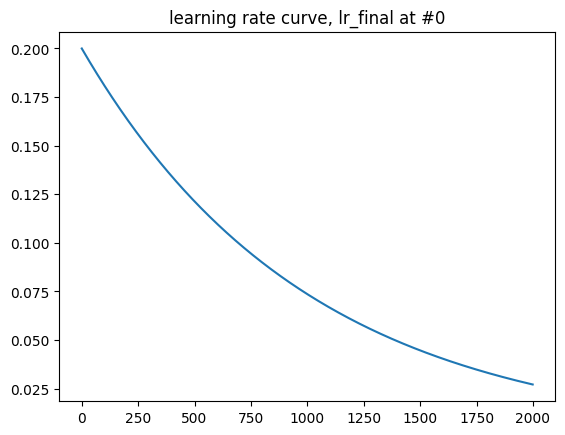

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[100]	fit's multi_logloss: 0.607359	val's multi_logloss: 0.958298
[200]	fit's multi_logloss: 0.326338	val's multi_logloss: 0.862142
[300]	fit's multi_logloss: 0.180957	val's multi_logloss: 0.814517
[400]	fit's multi_logloss: 0.101295	val's multi_logloss: 0.79033
[500]	fit's multi_logloss: 0.0570826	val's multi_logloss: 0.781777
[600]	fit's multi_logloss: 0.0325276	val's multi_logloss: 0.767001
[700]	fit's multi_logloss: 0.0186747	val's multi_logloss: 0.769629
[800]	fit's multi_logloss: 0.0108266	val's multi_logloss: 0.772534
[900]	fit's multi_logloss: 0.00632361	val's multi_logloss: 0.773266
[1000]	fit's multi_logloss: 0.00369351	val's multi_logloss: 0.776425
[1100]	fit's multi_logloss: 0.00216399	val's multi_logloss: 0.786305
[1200]	fit's multi_logloss: 0.00127072	val's multi_logloss: 0.794535
[1300]	fit's multi_logloss: 0.000748354	val's multi_logloss: 0.806971
[1400]	fit's multi_logloss: 0.000441779	val's multi_logloss: 0.816231
[1500]	fit's multi_logloss: 0.000260859	val's multi_lo

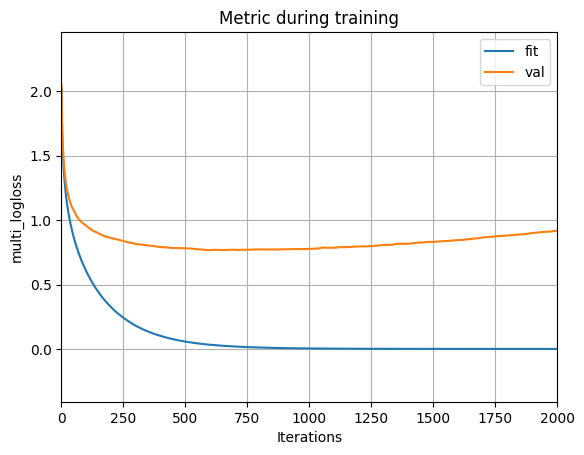

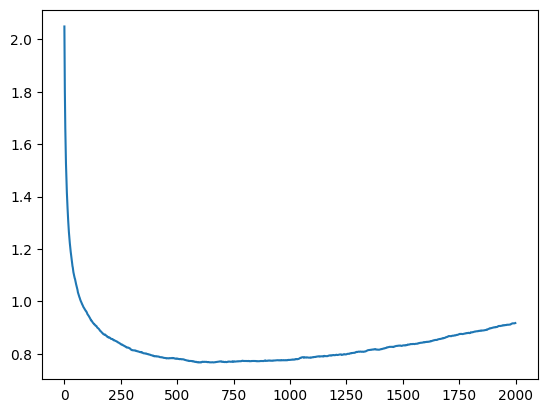

Train Accuary: 100.00%


In [27]:
from sklearn.model_selection import train_test_split

X_fit, X_val, y_fit, y_val = train_test_split(
    featmap_3hop, y_train_200K, test_size=0.01, random_state=42)

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

fit = lgb.Dataset(
    X_fit, y_fit,
)

val = lgb.Dataset(
    X_val, y_val,
)

maxdepth = 6
lr0 = 0.2 # make sure GD at the begining
lr_final = 0.2 # make sure final converge faster
k = -0.001 # lower -> more smooth
num_rounds = 2000
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
plt.plot(rounds, rounds_lr)
plt.title("learning rate curve, lr_final at #" + str(int(math.log(lr_final/lr0)/k)) )
plt.show()

evals_result = {} 

t0 = time.time()
model = lgb.train(
    params={
        'learning_rate': 0.1,
        'max_depth': maxdepth,
        # 'num_leaves': 10,
        'device' : 'gpu',
        # 'gpu_platform_id' : 0,
        # 'gpu_device_id' : 0 ,
        # 'num_gpu' : 2,
        'objective': 'multiclass',
        'num_class':10,
        # 'feature_fraction': 0.4,
        # 'bagging_fraction': 0.6,
        # 'bagging_freq': 10,
        'verbose' : -1
           },
    train_set=fit,
    num_boost_round=num_rounds,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    # early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=100,
    # fobj=fl.lgb_obj,
    # feval=fl.lgb_eval,
    callbacks=[lgb.reset_parameter(learning_rate=lambda \
        current_round: max(lr0 * math.e**(k * current_round), lr_final))]
)

print("training time:", time.time()-t0)
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

plt.plot(evals_result['val']['multi_logloss'])
plt.show()

y_preds =model.predict(X_fit)
y_train_preds = []
for x in y_preds:
    y_train_preds.append(np.argmax(x))

y_train_preds = np.array(y_train_preds)

train_accuracy = accuracy_score(y_fit, y_train_preds)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))


Test Accuary: 77.74%


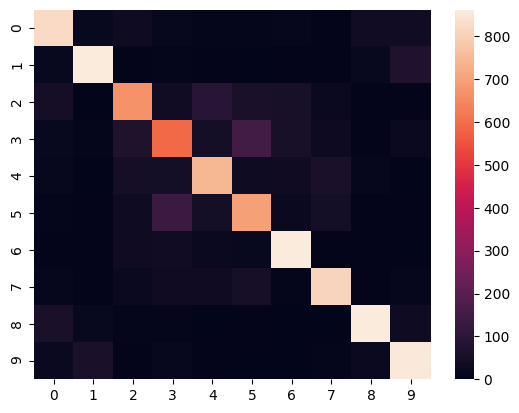

In [28]:
# feattest_3hop
t0 = time.time()
y_test_preds = []
y_preds =model.predict(feattest_3hop)
for x in y_preds:
    y_test_preds.append(np.argmax(x))
y_test_preds = np.array(y_test_preds)

pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))
# print('inference time:', time.time() - t0)

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()

# DFT Analysis of selected 5000 features from 3 hops

15117
468 2.271580795392494


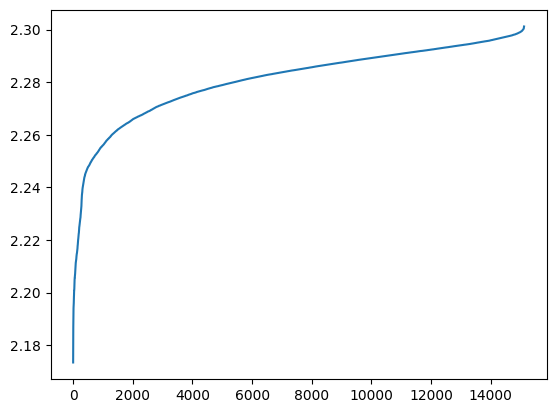

In [7]:
DFT_3hop = DFThop1 + DFThop2 + DFThop3

print(len(DFT_3hop))

idx = np.argsort(DFT_3hop)[3000 - 1]
print(idx, DFT_3hop[idx])

plt.plot(sorted(DFT_3hop))
plt.show()

In [8]:
DFT_th = DFT_3hop[idx]
DFThop1_select = np.where(DFThop1 <= DFT_th)[0]
print(len(DFThop1_select))
# print(DFThop1_select[:3])

DFThop2_select = np.where(DFThop2 <= DFT_th)[0]
print(len(DFThop2_select))
# print(DFThop2_select[:3])

DFThop3_select = np.where(DFThop3 <= DFT_th)[0]
print(len(DFThop3_select))
# print(DFThop3_select[:3])

DFT_3hop_select = [DFThop1_select, DFThop2_select, DFThop3_select]

1996
881
123


3000


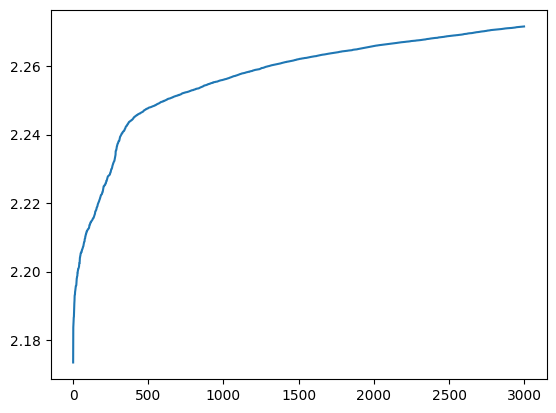

In [9]:
# DFT_3hop_3000 = np.concatenate(np.array(DFThop1)[DFThop1_select], np.array(DFThop2)[DFThop2_select],\
                # np.array(DFThop3)[DFThop3_select])ap
                
DFT_3hop_3000 = list(np.array(DFThop1)[DFThop1_select]) + list(np.array(DFThop2)[DFThop2_select])\
                + list(np.array(DFThop3)[DFThop3_select])
                
DFT_3hop_3000_idx = np.argsort(DFT_3hop_3000)
print(len(DFT_3hop_3000_idx))

plt.plot(np.array(DFT_3hop_3000)[DFT_3hop_3000_idx])
plt.show()

In [10]:
feattrain_3hop_3000 = []
for hopidx in [2, 1, 0]:
    
    feattmp = feattrain[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape, len(DFT_3hop_select[hopidx]))
    feattmp = feattmp[:,DFT_3hop_select[hopidx]]
    print(feattmp.shape)
    feattrain_3hop_3000.append(feattmp)

feattest_3hop_3000 = []
for hopidx in [2, 1, 0]:
    
    feattmp = feattest[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape, len(DFT_3hop_select[hopidx]))
    feattmp = feattmp[:,DFT_3hop_select[hopidx]]
    print(feattmp.shape)
    feattest_3hop_3000.append(feattmp)
    


(200000, 123)
(200000, 881)
(200000, 1996)
(10000, 123)
(10000, 881)
(10000, 1996)


In [11]:
feattrain_3hop_3000 = np.concatenate(feattrain_3hop_3000, axis= -1)
print(feattrain_3hop_3000.shape)
feattest_3hop_3000 = np.concatenate(feattest_3hop_3000 , axis= -1)
print(feattest_3hop_3000.shape)

print(y_train_200K.shape, y_test.shape)

(200000, 3000)
(10000, 3000)
(200000, 1) (10000, 1)


In [16]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
accrecord = []

trainmap_dft = feattrain_3hop_3000
testmap_dft = feattest_3hop_3000
print("DFT feat for selection:", trainmap_dft.shape, testmap_dft.shape)

num_rounds = 2000
maxdepth = 5
lr0 = 0.2  # make sure GD at the begining
lr_final = 0.1  # make sure final converge faster
k = -0.001  # lower -> more smooth
# num_rounds = 10
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
    
# for ratio in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
for ratio in [1.0]:
    
    featdim = int(ratio * len(DFT_3hop_3000_idx))
    print("DFT feat dim:", featdim)
    featselect = DFT_3hop_3000_idx[:featdim]

    featselectmap = {}
    featselectmap[0] = featselect

    trainmap = trainmap_dft[:, featselect]
    testmap = testmap_dft[:, featselect]
    print(trainmap.shape, testmap.shape)

    X_fit, X_val, y_fit, y_val = train_test_split(
        trainmap, y_train_200K, test_size=0.01, random_state=42)

    fit = lgb.Dataset(
        X_fit, y_fit,
    )

    val = lgb.Dataset(
        X_val, y_val,
    )


    evals_result = {} 

    model = lgb.train(
        params={
            'learning_rate': lr0,
            'max_depth': maxdepth,
            # 'num_leaves': 10,
            'device' : 'gpu',
            # 'gpu_platform_id' : 0,
            # 'gpu_device_id' : 0 ,
            # 'num_gpu' : 2,
            'objective': 'multiclass',
            'num_class':10,
            # 'feature_fraction': 0.4,
            # 'bagging_fraction': 0.6,
            # 'bagging_freq': 10,
            'verbose' : -1
            },
        train_set=fit,
        num_boost_round=num_rounds,
        valid_sets=(fit, val),
        valid_names=('fit', 'val'),
        # early_stopping_rounds=200,
        evals_result=evals_result,
        verbose_eval=400,
        # fobj=fl.lgb_obj,
        # feval=fl.lgb_eval,
        callbacks=[lgb.reset_parameter(learning_rate=lambda \
            current_round: max(lr0 * math.e**(k * current_round), lr_final))]
    )
    y_test_preds = []
    # y_preds =model.predict(feattest)
    y_preds = model.predict(testmap)
    for x in y_preds:
        y_test_preds.append(np.argmax(x))
    y_test_preds = np.array(y_test_preds)

    pred_accuracy_score = accuracy_score(y_test, y_test_preds)
    print("Test Accuary: %.2f%%" % (pred_accuracy_score * 100.0))
    accrecord.append(pred_accuracy_score * 100.0)

DFT feat for selection: (200000, 3000) (10000, 3000)
DFT feat dim: 3000
(200000, 3000) (10000, 3000)


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[400]	fit's multi_logloss: 0.236965	val's multi_logloss: 0.848792
[800]	fit's multi_logloss: 0.0832229	val's multi_logloss: 0.800695
[1200]	fit's multi_logloss: 0.0332177	val's multi_logloss: 0.78738
[1600]	fit's multi_logloss: 0.013666	val's multi_logloss: 0.784624
[2000]	fit's multi_logloss: 0.00568898	val's multi_logloss: 0.795857
Test Accuary: 75.53%


# Elbow of Elbow

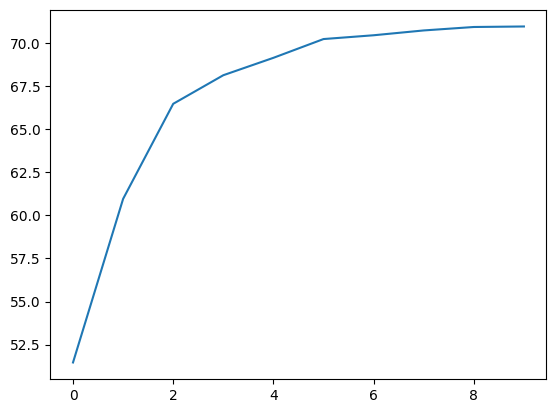

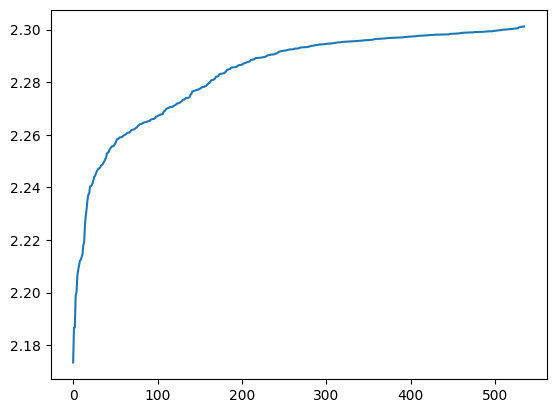

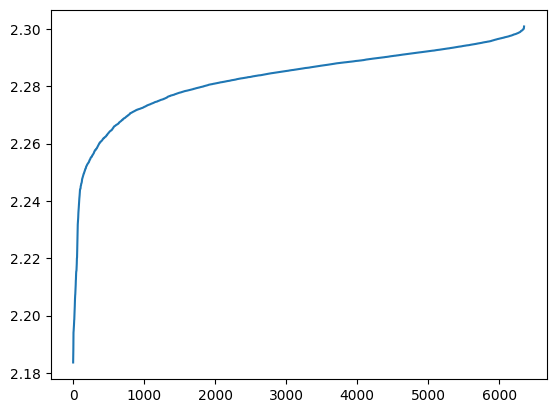

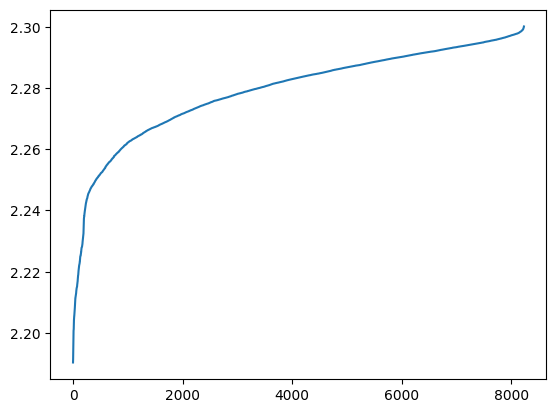

In [51]:
hop3acc = [
51.46,
60.96,
66.48,
68.14,
69.15,
70.24,
70.46,
70.74,
70.94,
70.97]

plt.plot(hop3acc)
plt.show()

plt.plot(sorted(DFThop3))
plt.show()

plt.plot(sorted(DFThop2))
plt.show()

plt.plot(sorted(DFThop1))
plt.show()

In [59]:
feattrain_3hop = []
DFT_elbow = []
select_ratio = [ 0.2, 0.4, 0.3]
for hopidx in [2,1, 0]:
    
    feattmp = feattrain[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape)
    featdim = int(select_ratio[hopidx] * feattmp.shape[-1])
    # print(featdim)
    featselect = np.argsort(DFTresults[hopidx])[:featdim]
    DFT_elbow.append(np.array(DFTresults[hopidx])[featselect])
    feattmp = feattmp[:,featselect]
    # print(feattmp.shape)
    feattrain_3hop.append(feattmp)

In [60]:
feattest_3hop = []
select_ratio = [ 0.2, 0.4, 0.3]
for hopidx in [2,1, 0]:
    
    feattmp = feattest[hopidx + 1]
    feattmp = feattmp.reshape((feattmp.shape[0], -1))
    # print(feattmp.shape)
    featdim = int(select_ratio[hopidx] * feattmp.shape[-1])
    # print(featdim)
    featselect = np.argsort(DFTresults[hopidx])[:featdim]
    feattmp = feattmp[:,featselect]
    # print(feattmp.shape)
    feattest_3hop.append(feattmp)

In [63]:
feattrain_3hop_elbow = np.concatenate(feattrain_3hop, axis= -1)
print(feattrain_3hop_elbow.shape)
feattest_3hop_elbow = np.concatenate(feattest_3hop, axis= -1)
print(feattest_3hop_elbow.shape)

(200000, 4346)
(10000, 4346)


4346


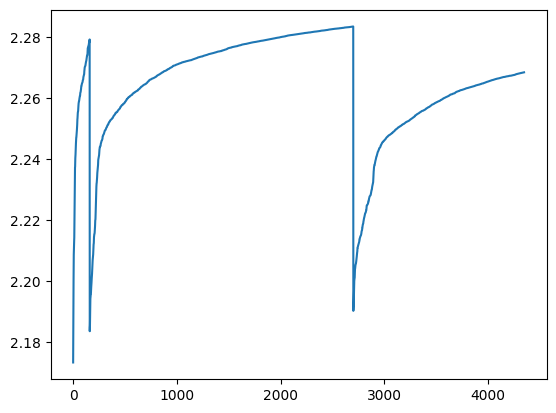

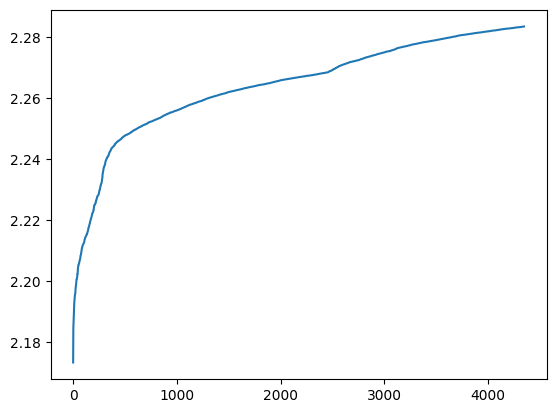

In [64]:
DFT_elbow_concate = np.concatenate(DFT_elbow)
print(len(DFT_elbow_concate))
plt.plot(DFT_elbow_concate)
plt.show()


plt.plot(sorted(DFT_elbow_concate))
plt.show()

In [65]:
dft_elbow_idx = np.argsort(DFT_elbow_concate)

feattrain_3hop = feattrain_3hop_elbow[:,dft_elbow_idx[:3000]]
feattest_3hop = feattest_3hop_elbow[:,dft_elbow_idx[:3000]]

print(feattrain_3hop.shape, feattest_3hop.shape)

(200000, 3000) (10000, 3000)


train data: (198000, 3000) (198000, 1)
val data: (2000, 3000) (2000, 1)
train data: (198000, 3000) (198000, 1)
val data: (2000, 3000) (2000, 1)


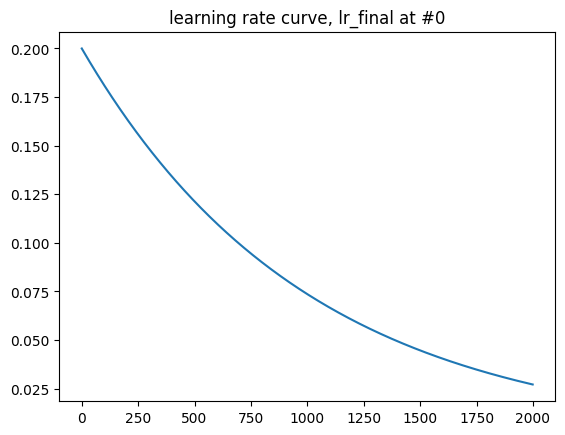

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/lightgbm/basic.py:169: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[100]	fit's multi_logloss: 0.643512	val's multi_logloss: 0.980783
[200]	fit's multi_logloss: 0.363176	val's multi_logloss: 0.890523
[300]	fit's multi_logloss: 0.21159	val's multi_logloss: 0.848333
[400]	fit's multi_logloss: 0.123962	val's multi_logloss: 0.823884
[500]	fit's multi_logloss: 0.0732509	val's multi_logloss: 0.809118
[600]	fit's multi_logloss: 0.0434628	val's multi_logloss: 0.800466
[700]	fit's multi_logloss: 0.0259878	val's multi_logloss: 0.799144
[800]	fit's multi_logloss: 0.0156438	val's multi_logloss: 0.798994
[900]	fit's multi_logloss: 0.00944536	val's multi_logloss: 0.799452
[1000]	fit's multi_logloss: 0.00577256	val's multi_logloss: 0.802941
[1100]	fit's multi_logloss: 0.0035108	val's multi_logloss: 0.80754
[1200]	fit's multi_logloss: 0.00214263	val's multi_logloss: 0.817382
[1300]	fit's multi_logloss: 0.00131246	val's multi_logloss: 0.832354
[1400]	fit's multi_logloss: 0.000803265	val's multi_logloss: 0.838353
[1500]	fit's multi_logloss: 0.000492829	val's multi_loglo

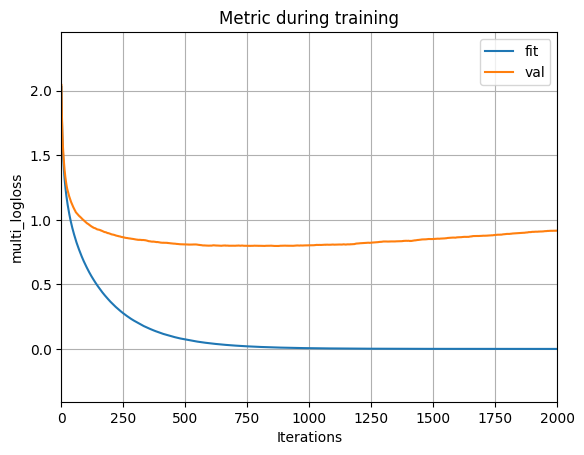

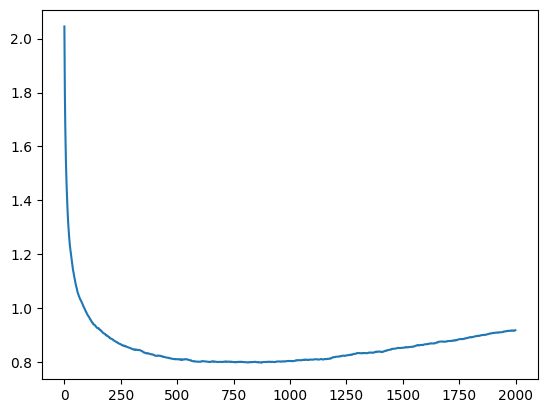

Train Accuary: 100.00%


In [66]:


from sklearn.model_selection import train_test_split

X_fit, X_val, y_fit, y_val = train_test_split(
    feattrain_3hop, y_train_200K, test_size=0.01, random_state=42)

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

import lightgbm as lgb
import math
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn

print("train data:", X_fit.shape, y_fit.shape)
print("val data:", X_val.shape, y_val.shape)

fit = lgb.Dataset(
    X_fit, y_fit,
)

val = lgb.Dataset(
    X_val, y_val,
)

maxdepth = 6
lr0 = 0.2 # make sure GD at the begining
lr_final = 0.2 # make sure final converge faster
k = -0.001 # lower -> more smooth
num_rounds = 2000
rounds = np.arange(num_rounds)
rounds_lr = lr0 * math.e**(k * rounds)
plt.plot(rounds, rounds_lr)
plt.title("learning rate curve, lr_final at #" + str(int(math.log(lr_final/lr0)/k)) )
plt.show()

evals_result = {} 

t0 = time.time()
model = lgb.train(
    params={
        'learning_rate': 0.1,
        'max_depth': maxdepth,
        # 'num_leaves': 10,
        'device' : 'gpu',
        # 'gpu_platform_id' : 0,
        # 'gpu_device_id' : 0 ,
        # 'num_gpu' : 2,
        'objective': 'multiclass',
        'num_class':10,
        # 'feature_fraction': 0.4,
        # 'bagging_fraction': 0.6,
        # 'bagging_freq': 10,
        'verbose' : -1
           },
    train_set=fit,
    num_boost_round=num_rounds,
    valid_sets=(fit, val),
    valid_names=('fit', 'val'),
    # early_stopping_rounds=200,
    evals_result=evals_result,
    verbose_eval=100,
    # fobj=fl.lgb_obj,
    # feval=fl.lgb_eval,
    callbacks=[lgb.reset_parameter(learning_rate=lambda \
        current_round: max(lr0 * math.e**(k * current_round), lr_final))]
)

print("training time:", time.time()-t0)
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

plt.plot(evals_result['val']['multi_logloss'])
plt.show()

y_preds =model.predict(X_fit)
y_train_preds = []
for x in y_preds:
    y_train_preds.append(np.argmax(x))

y_train_preds = np.array(y_train_preds)

train_accuracy = accuracy_score(y_fit, y_train_preds)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))


Test Accuary: 76.19%


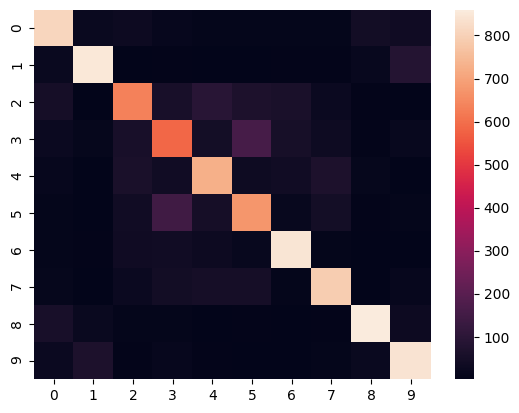

In [102]:
# feattest_3hop
t0 = time.time()
y_test_preds = []
y_preds =model.predict(feattest_3hop)
for x in y_preds:
    y_test_preds.append(np.argmax(x))
y_test_preds = np.array(y_test_preds)

pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))
# print('inference time:', time.time() - t0)

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()

In [105]:
print(cnf_matrix)
acc = []
for i in range(10):
    
    acctmp = cnf_matrix[i][i] / sum(cnf_matrix[i])
    acc.append(acctmp)
    print(acctmp)
    
print(np.argsort(acc))

[[813  24  30  17  10  10   8   9  42  37]
 [ 22 851   4   5   3   2   6   5  19  83]
 [ 50   3 633  57  92  68  59  27   7   4]
 [ 25  14  58 585  47 162  52  34   5  18]
 [ 17   2  59  41 728  33  38  67  12   3]
 [  8   3  39 148  50 673  18  46   7   8]
 [  9   6  37  40  30  20 846   8   3   1]
 [ 12   4  25  42  49  51   9 790   2  16]
 [ 55  23   8  10   4   5   1   5 860  29]
 [ 26  68   6  17   6   3   1  10  23 840]]
0.813
0.851
0.633
0.585
0.728
0.673
0.846
0.79
0.86
0.84
[3 2 5 4 7 0 9 6 1 8]


# SFG on 6 classes:

In [1]:
feattrain_sfg = feattrain_3hop_elbow[:,dft_elbow_idx[:3000]]
feattest_sfg = feattest_3hop_elbow[:,dft_elbow_idx[:3000]]

print(feattrain_sfg.shape)
print(feattest_sfg.shape)

NameError: name 'feattrain_3hop_elbow' is not defined

# MLP for complementary

# Test Hummingbird

In [107]:
dft_elbow_idx = np.argsort(DFT_elbow_concate)

feattrain_3hop = feattrain_3hop_elbow[:,dft_elbow_idx[:3000]]
feattest_3hop = feattest_3hop_elbow[:,dft_elbow_idx[:3000]]

print(feattrain_3hop.shape, feattest_3hop.shape)

(200000, 3000) (10000, 3000)


In [95]:
lgb_hm_model = lgb.LGBMClassifier(n_estimators = 1, 
                           max_depth= 5,
                           learning_rate = 0.3,
                           device = 'gpu',
                           objective = 'multiclass',
                           num_class =10,
                           verbose = -1
                           )
lgb_hm_model.fit(feattrain_3hop, y_train_200K)

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(device='gpu', learning_rate=0.3, max_depth=6, n_estimators=1,
               num_class=10, objective='multiclass', verbose=-1)

Test Accuary: 27.02%


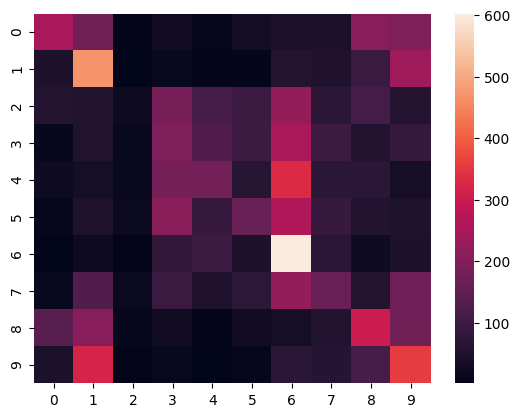

In [96]:
# y_test_preds = []
# y_preds = lgb_hm_model.predict(feattest_3hop)
# for x in y_preds:
#     y_test_preds.append(np.argmax(x))
# y_test_preds = np.array(y_test_preds)

y_test_preds = lgb_hm_model.predict(feattest_3hop)
pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()

In [97]:
from hummingbird.ml import convert, load

lgb_hm_model_converted = convert(lgb_hm_model, 'pytorch')

print(lgb_hm_model_converted.model.parameters)

Finished loading model, total used 1 iterations
<bound method Module.parameters of Executor(
  (_operators): ModuleList(
    (0): PerfectTreeTraversalGBDTImpl(
      (nodes): ParameterList(
          (0): Parameter containing: [torch.int64 of size 20]
          (1): Parameter containing: [torch.int64 of size 40]
          (2): Parameter containing: [torch.int64 of size 80]
          (3): Parameter containing: [torch.int64 of size 160]
          (4): Parameter containing: [torch.int64 of size 320]
      )
      (biases): ParameterList(
          (0): Parameter containing: [torch.float32 of size 20]
          (1): Parameter containing: [torch.float32 of size 40]
          (2): Parameter containing: [torch.float32 of size 80]
          (3): Parameter containing: [torch.float32 of size 160]
          (4): Parameter containing: [torch.float32 of size 320]
      )
    )
  )
)>


Test Accuary: 63.10%


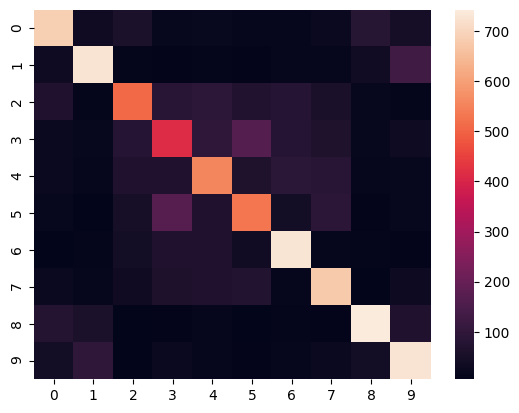

In [75]:
y_test_preds = lgb_hm_model_converted.predict(feattest_3hop)

pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()